In [ ]:
!pip install -U tensorflow-text

In [2]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
file_path = "/spam.csv"
df = pd.read_csv(file_path)

# New section

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.Category.value_counts() # imbalanced dataset

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
sample_size = 747
df_spam = df[df["Category"] == 'spam']
df_ham  = df[df["Category"] == 'ham'].sample(sample_size)

In [7]:
df_spam.shape, df_ham.shape

((747, 2), (747, 2))

In [8]:
df_final = pd.concat([df_spam, df_ham], axis = 0)

In [9]:
df_final.shape

(1494, 2)

In [10]:
df_final.Category.value_counts() # balanced dataset

spam    747
ham     747
Name: Category, dtype: int64

In [11]:
df_final["spam"] = df_final["Category"].apply(lambda x:1 if x == "spam" else 0)

In [12]:
df_final.head()

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1


In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(df_final["Message"], df_final["spam"], stratify= df_final["spam"])

In [14]:
x_train.shape, x_test.shape

((1120,), (374,))

In [ ]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_model = hub.KerasLayer(preprocess_url)
bert_model = hub.KerasLayer(encoder_url)

In [16]:
def get_sentence_embedding(sentence):
  preprocess_model = hub.KerasLayer(preprocess_url)
  preprocessed_text = preprocess_model(sentence)

  bert_model = hub.KerasLayer(encoder_url)
  outputs = bert_model(preprocessed_text)
  return outputs["pooled_output"]

In [17]:
get_sentence_embedding(["we will write simple code"," All opinions expressed in this video"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.7990296 , -0.21957132,  0.3276818 , ...,  0.14205743,
        -0.6098242 ,  0.7692286 ],
       [-0.86739355, -0.36011145, -0.48704946, ..., -0.20020416,
        -0.55299425,  0.80000496]], dtype=float32)>

In [18]:
Embed =  get_sentence_embedding([
    "banana",
    "orange",
    "apple",
    "musk",
    "bus"
])

In [19]:
Embed

<tf.Tensor: shape=(5, 768), dtype=float32, numpy=
array([[-0.7606915 , -0.14219373,  0.49604753, ...,  0.42165396,
        -0.5322139 ,  0.8031215 ],
       [-0.83630806, -0.23830138,  0.38453618, ...,  0.45564768,
        -0.6078618 ,  0.8278895 ],
       [-0.8196456 , -0.29609606,  0.20951846, ...,  0.25593424,
        -0.5874298 ,  0.84345555],
       [-0.93887204, -0.31643882, -0.8159828 , ..., -0.70504534,
        -0.7072642 ,  0.9134349 ],
       [-0.73708874, -0.1585213 ,  0.26595268, ...,  0.3851067 ,
        -0.54682916,  0.7989956 ]], dtype=float32)>

In [20]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([Embed[1]],[Embed[3]])

array([[0.796335]], dtype=float32)

**Building** **a** **Model**  (functional)

In [21]:
# BERT layers
text_input = tf.keras.layers.Input(shape=(), dtype = tf.string, name = "text")
preprocessed_text = preprocess_model(text_input)
outputs = bert_model(preprocessed_text)

# Neural network layers
input_layer = tf.keras.layers.Dropout(0.1, name = "dropout")(outputs["pooled_output"])
output_layer = tf.keras.layers.Dense(1, activation = "sigmoid", name ="output")(input_layer)

# construct final model

model = tf.keras.Model(inputs = [text_input], outputs = [output_layer])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [23]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = "accuracy"),
    tf.keras.metrics.Precision(name = "precision"),
    tf.keras.metrics.Recall(name ="recall")
]

model.compile(optimizer= "adam",
              loss = "binary_crossentropy",
              metrics = METRICS)

In [24]:
model.fit(x_train, y_train, epochs = 10)

Epoch 1/10
35/35 [==============================] - 24s 327ms/step - loss: 0.6756 - accuracy: 0.5982 - precision: 0.5914 - recall: 0.6357
Epoch 2/10
35/35 [==============================] - 11s 325ms/step - loss: 0.5379 - accuracy: 0.7884 - precision: 0.8148 - recall: 0.7464
Epoch 3/10
35/35 [==============================] - 11s 326ms/step - loss: 0.4637 - accuracy: 0.8482 - precision: 0.8283 - recall: 0.8786
Epoch 4/10
35/35 [==============================] - 11s 323ms/step - loss: 0.4089 - accuracy: 0.8705 - precision: 0.8487 - recall: 0.9018
Epoch 5/10
35/35 [==============================] - 12s 336ms/step - loss: 0.3807 - accuracy: 0.8768 - precision: 0.8663 - recall: 0.8911
Epoch 6/10
35/35 [==============================] - 12s 332ms/step - loss: 0.3523 - accuracy: 0.8946 - precision: 0.8746 - recall: 0.9214
Epoch 7/10
35/35 [==============================] - 12s 332ms/step - loss: 0.3358 - accuracy: 0.8902 - precision: 0.8840 - recall: 0.8982
Epoch 8/10
35/35 [================

In [25]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 7s 352ms/step - loss: 0.2723 - accuracy: 0.9091 - precision: 0.8964 - recall: 0.9251


[0.2723112404346466,
 0.9090909361839294,
 0.8963730335235596,
 0.9251337051391602]

In [27]:
y_pred = model.predict(x_test)

12/12 [==============================] - 4s 325ms/step


In [29]:
y_pred = y_pred.flatten()

In [33]:
import numpy as np

y_predicted = np.where(y_pred>0.5,1,0)
y_predicted

array([1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,

In [36]:
y_test=np.array(y_test)

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test,y_predicted )

Text(50.722222222222214, 0.5, 'Truth')

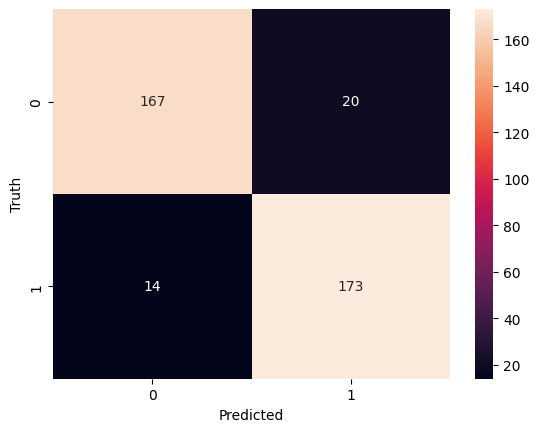

In [40]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot = True,fmt = 'd' )
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [41]:
print(classification_report(y_predicted, y_test))


              precision    recall  f1-score   support

           0       0.89      0.92      0.91       181
           1       0.93      0.90      0.91       193

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374

